In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

C:\Users\hubak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556181
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
bitcoin_fg = fs.get_feature_group(
    name='bitcoin_price',
    version=2,
)

In [4]:
training_data = bitcoin_fg.select_all()

In [5]:
version = 1 
feature_view_training = fs.get_or_create_feature_view(
    name='bitcoin_training_fv',
    version=version,
    query=training_data,
)

In [8]:
X, _ = feature_view_training.get_training_data(training_dataset_version=3,
    primary_keys=True,
    event_time=True
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.34s) 


In [9]:
sorted_X = X.sort_values(by='timestamp')

In [10]:
final_X = sorted_X.drop(columns=['timestamp', 'date'])

In [11]:
y = final_X.pop('tomorrow')

In [13]:
X_train = final_X.iloc[:3000]
y_train = y.iloc[:3000]

# Exclude the last row for testing data
X_test = final_X.iloc[3000:-1]
y_test = y.iloc[3000:-1]

In [16]:
import xgboost as xgb

model = xgb.XGBRegressor(learning_rate=0.1)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MSE: 4320240.167102591
RMSE: 2078.5187435052376
R^2: 0.9784045578059739
MAE: 1396.948953276699


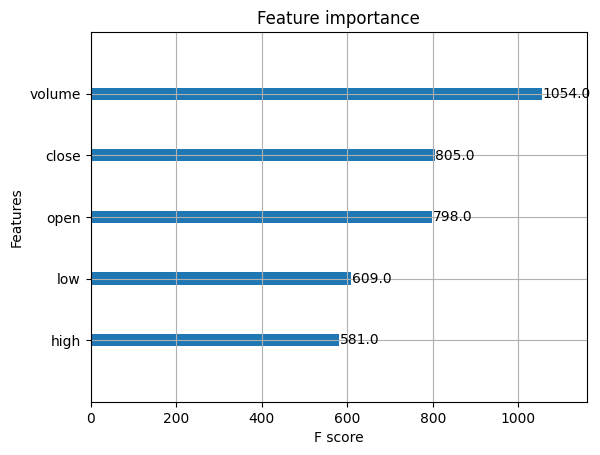

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    model, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

In [24]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [25]:
mr = project.get_model_registry()

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

Connected. Call `.close()` to terminate connection gracefully.


In [26]:
import os
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

joblib.dump(model, model_dir + "/bitcoin_price_prediction_model.pkl")

['model/bitcoin_price_prediction_model.pkl']

In [27]:
xgb_model = mr.python.create_model(
    name="bitcoin_price_prediction_model",
    metrics={
        "MAE score": mae,
        "MSE score": mse,
        "RMSE score": rmse,
        "Rsquared score": r2
    },
    model_schema=model_schema,
    input_example=X_train.sample()
)
xgb_model.save(model_dir)

Uploading: 100.000%|██████████| 334874/334874 elapsed<00:02 remaining<00:00  3.65it/s]
Uploading: 100.000%|██████████| 77/77 elapsed<00:01 remaining<00:0002<00:05,  1.39s/it]
Uploading: 100.000%|██████████| 554/554 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/556181/models/bitcoin_price_prediction_model/1


Model(name: 'bitcoin_price_prediction_model', version: 1)